# IS319 - Deep Learning

## TP1 - Neural networks

The goal of this TP is to implement a simple feedforward neural network, but without the use of libraries like PyTorch or TensorFlow. We will only use NumPy.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Activation function and its derivative

**(Question)** Implement the following activation function and its respective gradient (vector of partial derivatives). These should be applied element-wise to the input vector `a`.

In [4]:
def sigmoid(a):
    '''Return the element-wise sigmoid of the input vector.'''
    return 1 / (1 + np.exp(-a))

def d_sigmoid(a):
    '''Return the partial derivatives of the sigmoid function
    with respect to the input vector.'''
    return sigmoid(a) * (1 - sigmoid(a))

In [5]:
a = np.random.randn(100)
assert np.all(sigmoid(a) >= 0.)
assert np.all(sigmoid(a) <= 1.)
assert sigmoid(0.) == 0.5
assert np.all(d_sigmoid(a) >= 0.)
assert np.all(d_sigmoid(a) <= 0.25)

## 2. Loss function and its derivative

**(Question)** Implement the following loss function and its respective gradient (vector of partial derivatives).

`y` and `d` correspond to predictions and ground-truth labels respectively. They are assumed to be be matrices of size `n_classes * n_samples`.

In [6]:
def squared_error(y, d):
    '''Return a scalar corresponding to the sum of squared errors.'''
    # The sum instead of mean will be more convenient for this TP
    return 0.5 * np.sum((y - d) ** 2)

def d_squared_error(y, d):
    '''Return the vector of partial derivatives of the sum of
    squared errors with respect to the predictions.'''
    return y - d

In [7]:
y = np.random.randn(3, 100)
d = np.random.randn(3, 100)
assert squared_error(y, d) >= 0.
assert d_squared_error(y, d).shape == y.shape

## 3. Neural network architecture

We will implement a simple fully-connected neural network with **one hidden layer** and **one output layer**.

This neural network is defined by a number of inputs, a number of hidden units, and a number of output units.

The activation function will be sigmoid and the loss function will be the sum of squared errors, both implemented above.

**(Question)** Complete the class below to initialize the weights and biases randomly.

In [8]:
class NeuralNetwork():
    def __init__(self, n_input, n_hidden, n_output):
        '''Initialize a neural network with `n_input` input neurons,
        `n_hidden` hidden neurons and `n_output` output neurons.'''
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.init_weights()
        
    def init_weights(self):
        '''Initialize random weights with correct sizes in attributes `W1`, `b1`, `W2` and `b2`.'''
        self.W1 = np.random.randn(self.n_hidden, self.n_input)
        self.b1 = np.random.randn(self.n_hidden, 1)
        
        self.W2 = np.random.randn(self.n_output, self.n_hidden)
        self.b2 = np.random.randn(self.n_output, 1)

In [9]:
nn = NeuralNetwork(64, 32, 3)
assert nn.W1.ndim == 2
assert nn.b1.ndim == 2
assert nn.W2.ndim == 2
assert nn.b2.ndim == 2

## 4. Forward pass

The forward pass is defined as:
$$\begin{align*}
\mathbf{h}_1 &= \sigma(\mathbf{a}_1) \quad\text{with}\quad \mathbf{a}_1 = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \\
\mathbf{y} &= \sigma(\mathbf{a}_2) \quad\text{with}\quad \mathbf{a}_2 = \mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2
\end{align*}$$

**(Question)** Implement the forward pass for input examples `X`. Save intermediate results `a1`, `h1` and `a2` into attributes (as they will be needed for the backpropagation algorithm).

In [10]:
class NeuralNetwork(NeuralNetwork): # (the method will be added to the `NeuralNetwork` class)
    def forward(self, X):
        # print("forward : ", self.W1.shape, X.shape)
        self.a1 = self.W1 @ X + self.b1
        h1 = sigmoid(self.a1)
        self.a2 = self.W2 @ h1 + self.b2
        
        self.y = sigmoid(self.a2)
        return self.y

In [11]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
y = nn.forward(X)
assert y.shape == (3, 100)

**(Question)** Implement the function below to obtain a classification decision from the network. To do that, apply the forward pass, then choose the class corresponding to the maximum output value.

In [12]:
class NeuralNetwork(NeuralNetwork): # (the method will be added to the `NeuralNetwork` class)
    def predict(self, X):
        proba = self.forward(X)
        return proba.argmax(axis=0)

In [13]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
y = nn.predict(X)
assert y.shape == (100,)
assert np.any(y == 0) or np.any(y == 1) or np.any(y == 2)

## 5. Backward pass

**(Question)** Implement the backward pass for input examples `X`, ground-truth `d`, predictions `y`.

*Advice 1:* start by working on weights `d_W2` and `d_W1`, then work on the biases `d_b2` and `d_b1`.

*Advice 2:* keep track of the shapes of each partial derivatives using comments.

In [14]:
class NeuralNetwork(NeuralNetwork):
    def backward(self, X, y, d):
        '''Compute the partial derivatives of the loss function
        with respect to all weights of the neural network.
        Return these in variables `d_W1`, `d_b1`, `d_W2` and `d_b2`.'''
        # Backpropagation for the output layer
        # You should compute d_ey, d_ya2, d_a2w2 and finally delta2
        # Then, you can compute d_W2 and d_b2
        d_ey = d_squared_error(y, d)
        d_ya2 = d_sigmoid(self.a2)
        d_a2w2 = sigmoid(self.a1)

        # print("d_ey : ", d_ey.shape)
        # print("d_ya2 : ", d_ya2.shape)
        # print("d_a2w2 : ", d_a2w2.shape)
        delta2 = d_ey * d_ya2
    
        d_W2 = delta2 @ d_a2w2.T
        d_b2 = np.sum(delta2, axis=1).reshape(self.n_output, 1)
        # d_b2 = d_b2.resize(d_b2.shape[0], 1)
        
        # Backpropagation for the hidden layer
        # You should compute d_h1a1 and finally delta1
        # Then, you can compute d_W1 and d_b1
        d_h1a1 = d_sigmoid(self.a1)
        delta1 = (self.W2.T @ delta2) * d_h1a1
        
        d_W1 =  delta1 @ X.T
        d_b1 = np.sum(delta1, axis=1).reshape(self.n_hidden, 1)
        # d_b1 = d_b1.resize(d_b1.shape[0], 1)
        return d_W1, d_b1, d_W2, d_b2

In [15]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
d = np.random.randint(0, 2, size=(3, 100))
y = nn.forward(X)
loss = squared_error(y, d)
d_W1, d_b1, d_W2, d_b2 = nn.backward(X, y, d)
print(d_b1.shape, nn.b1.shape)
print(d_b2.shape, nn.b2.shape)
assert d_W1.shape == nn.W1.shape
assert d_b1.shape == nn.b1.shape
assert d_W2.shape == nn.W2.shape
assert d_b2.shape == nn.b2.shape

(32, 1) (32, 1)
(3, 1) (3, 1)


## 6. Weights update with gradient descent

**(Question)** Complete the following code to implement one iteration of the training process:
- Apply the forward pass on training data and compute the loss
- Apply backpropagation to compute the gradient of the loss with respect to the network parameters
- Apply gradient descent to update the network parameters

In [16]:
class NeuralNetwork(NeuralNetwork):
    def train_iteration(self, X, d, lr=1e-2):
        # Apply the forward pass and compute the loss
        y = self.forward(X)
        loss = squared_error(y, d)
        
        # Apply backpropagation to compute the gradients
        d_W1, d_b1, d_W2, d_b2 = self.backward(X, y, d)
        
        # Apply gradient descent to update the weights
        self.W1 -= lr * d_W1
        self.W2 -= lr * d_W2
        self.b1 -= lr * d_b1
        self.b2 -= lr * d_b2
        return loss

In [17]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
d = np.random.randint(0, 2, size=(3, 100))
loss = nn.train_iteration(X, d, lr=100)
assert loss >= 0.

## 7. Mini-batch training loop

Now, we will implement the main training loop of our neural network.

We will use stochastic gradient descent with mini-batch: the weights will be updated by performing gradient descent on shuffled subsets of training data.

We will train the network for a number of epochs (an epoch is performed when the whole training set has been used with this mini-batch procedure).

**(Question)** Complete the code below to implement the training loop with minibatch stochastic gradient descent.

In [18]:
class NeuralNetwork(NeuralNetwork):
    def fit(self, X, d, batch_size, n_epochs=10, lr=1e-2):
        n_samples = X.shape[1]
        n_batches = (n_samples // batch_size) + 1
        for e in range(n_epochs):
            epoch_loss = 0.
            # Shuffle dataset
            permutation = np.random.permutation(n_samples)
            X, d = X[:, permutation], d[:, permutation]
            # Loop over each batch
            for b in range(0, n_samples, batch_size): # range(start, stop, step)
                # Grab the current batch in `X_batch` and `d_batch`
                X_batch = X[:, b:b+batch_size]
                d_batch = d[:, b:b+batch_size]
                # Apply training iteration and update epoch loss
                # print(X_batch.shape, d_batch.shape)
                loss = self.train_iteration(X_batch, d_batch, lr)
                epoch_loss += loss
            # Compute average epoch loss and print it
            epoch_loss = epoch_loss / n_samples
            print(f'MSE Loss: {epoch_loss} [{e+1}/{n_epochs}]')

## 8. Train the network on the MNIST dataset

The MNIST dataset is composed of 70000 greyscale images of handwritten digits: 60000 images for training and 10000 for testing.

It is included in the `mnist.tgz` archive provided with this TP.

In [19]:
!tar xvzf ./mnist.tgz
images_train = np.load('./mnist-train-images.npy')
labels_train = np.load('./mnist-train-labels.npy')
images_test = np.load('./mnist-test-images.npy')
labels_test = np.load('./mnist-test-labels.npy')

mnist-test-images.npy
mnist-test-labels.npy
mnist-train-images.npy
mnist-train-labels.npy


**(Question)** Reshape the images into vectors and normalize the pixel values between 0 and 1. Convert the labels into one-hot vectors (*i.e.* vectors full of 0 and with only a 1 for the corresponding class). Store the results into `X_train`, `y_train`, `X_test` and `y_test` variables. Make sure to reshape to the following:
- Input data: `n_features x n_samples`
- Labels: `n_classes x n_samples`

In [20]:
print(images_train.shape, labels_train.shape)  

def one_hot_encode(labels, n_classes):
    one_hot = np.zeros((labels.size, n_classes))
    
    for i in range(labels.size):
        one_hot[i][labels[i]] = 1
    
    return one_hot


X_train = images_train.reshape(-1, 28*28) / 255
X_test = images_test.reshape(-1, 28*28) / 255
X_train = X_train.T
X_test = X_test.T

y_train = one_hot_encode(labels_train, 10).T
y_test = one_hot_encode(labels_test, 10).T


print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
(784, 60000) (10, 60000)


In [21]:
assert np.all(X_train >= 0.) and np.all(X_train <= 1.)
assert np.all(X_test >= 0.) and np.all(X_test <= 1.)
assert np.all(np.unique(y_train) == np.array([0., 1.])) 
assert np.all(np.unique(y_test) == np.array([0., 1.]))
assert np.all(np.sum(y_train, axis=0) == 1.)
assert np.all(np.sum(y_test, axis=0) == 1.)

**(Question)** Initialize a neural network for MNIST with 32 hidden units and train it for 10 epochs with a batch size of 512.

In [22]:
mlp = NeuralNetwork(28*28, 32, 10)
mlp.fit(X_train, y_train, batch_size=512, n_epochs=10, lr=1e-2)

MSE Loss: 0.44006751029168 [1/10]
MSE Loss: 0.30194607150554553 [2/10]
MSE Loss: 0.25279065033472026 [3/10]
MSE Loss: 0.23180467333235596 [4/10]
MSE Loss: 0.21922811225767103 [5/10]
MSE Loss: 0.2097028187942049 [6/10]
MSE Loss: 0.18963410308921297 [7/10]
MSE Loss: 0.1707673313847538 [8/10]
MSE Loss: 0.16225591352640797 [9/10]
MSE Loss: 0.15623609132524255 [10/10]


**(Question)** Compute the classification accuracy on the train and test sets. To do that, you can use the predict function and compare them with the original labels (*i.e.* without one-hot encoding).

In [23]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

y_pred = mlp.predict(X_test)
mlp_accuracy = accuracy(labels_test, y_pred)
print(f'Accuracy: {mlp_accuracy}')

Accuracy: 0.7691


**(Question)** Compute and plot the confusion matrix for the test set. Which are the most difficult classes? Show some examples of misclassified images.

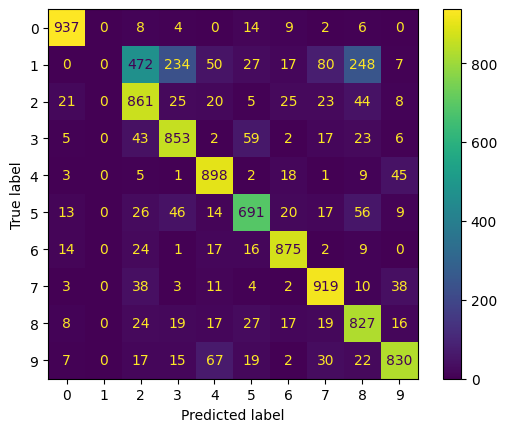

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(y_true, y_pred):
    cm = np.zeros((10, 10), dtype=int)
    for i in range(X_test.shape[1]):
        cm[y_true[i], y_pred[i]] += 1 # Adventage of one hotencoding
        
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

    disp.plot()
    plt.show()
    
plot_cm(labels_test, y_pred)

**(Question)** Play around with hyperparameters of the model. What happens when the batch size if very small? And very large?

In [25]:
large_batch_size = 10000
small_batch_size = 10


print(f"Training with batch size {large_batch_size}")
mlp_large = NeuralNetwork(28*28, 32, 10)
mlp_large.fit(X_train, y_train, batch_size=large_batch_size, n_epochs=10, lr=1e-2)

print(f"Training with batch size {small_batch_size}")
mlp_small = NeuralNetwork(28*28, 32, 10)
mlp_small.fit(X_train, y_train, batch_size=small_batch_size, n_epochs=10, lr=1e-2)

Training with batch size 10000
MSE Loss: 0.661395724197528 [1/10]
MSE Loss: 0.4999999893681426 [2/10]
MSE Loss: 0.4999999893669915 [3/10]
MSE Loss: 0.4999999893658424 [4/10]
MSE Loss: 0.4999999893646918 [5/10]
MSE Loss: 0.49999998936354106 [6/10]
MSE Loss: 0.49999998936239076 [7/10]
MSE Loss: 0.49999998936124046 [8/10]
MSE Loss: 0.4999999893600889 [9/10]
MSE Loss: 0.4999999893589385 [10/10]
Training with batch size 10
MSE Loss: 0.4328822537681163 [1/10]
MSE Loss: 0.2908685167730188 [2/10]
MSE Loss: 0.22023516470949975 [3/10]
MSE Loss: 0.1890111024145866 [4/10]
MSE Loss: 0.17116764573484086 [5/10]
MSE Loss: 0.15945805065677937 [6/10]
MSE Loss: 0.1510061276246941 [7/10]
MSE Loss: 0.14456714359812925 [8/10]
MSE Loss: 0.13950371092749236 [9/10]
MSE Loss: 0.13538600621788227 [10/10]


In [26]:

print("Accuracy of the large batch model")
y_pred_large = mlp_large.predict(X_test)
accuracy_large = accuracy(labels_test, y_pred_large)
print(f'Accuracy: {accuracy_large}')


print("Accuracy of the small batch model")
y_pred_small = mlp_small.predict(X_test)
accuracy_small = accuracy(labels_test, y_pred_small)
print(f'Accuracy: {accuracy_small}')

Accuracy of the large batch model
Accuracy: 0.1262
Accuracy of the small batch model
Accuracy: 0.8112


**(Question)** We have trained the network using the mean squared error as the loss function. In terms of probabilistic modeling, why is it not the best thing to do? Explain what should be done instead.

## 9. Extension to more than one hidden layer

**(Question)** Extend your neural network model to handle more than one hidden layer.

In [53]:
class NeuralNetwork():
    def __init__(self, n_input, n_hidden=[32], n_output=10):
        '''Initialize a neural network with `n_input` input neurons,
        `n_hidden` hidden neurons and `n_output` output neurons.'''
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.init_weights()
        
    def init_weights(self):
        '''Initialize random weights with correct sizes in attributes `W1`, `b1`, `W2` and `b2`.'''
        self.W1 = np.random.randn(self.n_hidden[0], self.n_input)
        self.b1 = np.random.randn(self.n_hidden[0], 1)
        
        self.Wh = np.array([np.random.randn(self.n_hidden[i], self.n_hidden[i-1]) for i in range(1, len(self.n_hidden))])
        self.bh = np.array([np.random.randn(self.n_hidden[i], 1) for i in range(1, len(self.n_hidden))])
        
        self.W2 = np.random.randn(self.n_output, self.n_hidden[-1])
        self.b2 = np.random.randn(self.n_output, 1)
    
    def forward(self, X):
        # print("forward : ", self.W1.shape, X.shape)
        self.a1 = self.W1 @ X + self.b1
        h1 = sigmoid(self.a1)
        
        self.a = [ np.random.randn(self.n_hidden[i], 1) if i!=0 else self.a1 for i in range(0, len(self.n_hidden))]
        self.h = [ np.random.randn(self.n_hidden[i], 1) if i!=0 else h1 for i in range(0, len(self.n_hidden))]
        for i in range(len(self.n_hidden) - 1):
            self.a[i] = self.Wh[i] @ self.h[i] + self.bh[i]
            self.h[i+1] = sigmoid(self.a[i])
            
        self.a2 = self.W2 @ self.h[-1] + self.b2
        self.y = sigmoid(self.a2)
        return self.y
    
    def backward(self, X, y, d):
        '''Compute the partial derivatives of the loss function
        with respect to all weights of the neural network.
        Return these in variables `d_W1`, `d_b1`, `d_W2` and `d_b2`.'''
        # Backpropagation for the output layer
        # You should compute d_ey, d_ya2, d_a2w2 and finally delta2
        # Then, you can compute d_W2 and d_b2
        d_ey = d_squared_error(y, d)
        d_ya2 = d_sigmoid(self.a2)
        d_a2w2 = sigmoid(self.a1)

        # print("d_ey : ", d_ey.shape)
        # print("d_ya2 : ", d_ya2.shape)
        # print("d_a2w2 : ", d_a2w2.shape)
        delta2 = d_ey * d_ya2
    
        d_W2 = delta2 @ d_a2w2.T
        d_b2 = np.sum(delta2, axis=1).reshape(self.n_output, 1)
        # d_b2 = d_b2.resize(d_b2.shape[0], 1)
        
        delta = [np.zeros((self.n_hidden[i], 1)) if i!=len(self.n_hidden) else delta2 for i in range(len(self.n_hidden))]
        d_Wh = [np.zeros((self.n_hidden[i], self.n_hidden[i-1])) if i!=len(self.n_hidden) else d_W2 for i in range(len(self.n_hidden))]
        d_bh = [np.zeros((self.n_hidden[i], 1)) if i!=len(self.n_hidden) else d_b2 for i in range(len(self.n_hidden))]
        
        print("delta :")
        for mat in delta:
            print(f"{mat.shape}")
        
        print("Wh :")
        for mat in d_Wh:
            print(f"{mat.shape}")
            
        print("bh :")
        for mat in d_bh:
            print(f"{mat.shape}")
        
        for i in range(0, len(self.n_hidden) - 1, -1):
            print(f"{i}/{len(self.n_hidden)}")
            d_hiai = d_sigmoid(self.a[i]) 
            delta[i] = (self.Wh[i+1].T @ delta[i+1]) * d_hiai

            d_Wh[i] = delta[i] @ self.h[i].T
            d_bh[i] = np.sum(delta[i], axis=1).reshape(self.n_hidden[i], 1)
        
        # Backpropagation for the hidden layer
        # You should compute d_h1a1 and finally delta1
        # Then, you can compute d_W1 and d_b1
        d_h1a1 = d_sigmoid(self.a1)
        delta1 = (self.W2.T @ delta[0]) * d_h1a1
        
        d_W1 =  delta1 @ X.T
        d_b1 = np.sum(delta1, axis=1).reshape(self.n_hidden[-1], 1)
        # d_b1 = d_b1.resize(d_b1.shape[0], 1)
        return d_W1, d_b1, d_Wh, d_bh, d_W2, d_b2
    
    def train_iteration(self, X, d, lr=1e-2):
        # Apply the forward pass and compute the loss
        y = self.forward(X)
        loss = squared_error(y, d)
        
        # Apply backpropagation to compute the gradients
        d_W1, d_b1, d_Wh, d_bh, d_W2, d_b2 = self.backward(X, y, d)
        
        # Apply gradient descent to update the weights
        self.W1 -= lr * d_W1
        self.W2 -= lr * d_W2
        self.b1 -= lr * d_b1
        self.b2 -= lr * d_b2
        
        for i in range(len(self.n_hidden) - 1):
            self.Wh[i] -= lr * d_Wh[i]
            self.bh[i] -= lr * d_bh[i]
        
        return loss
    
    def fit(self, X, d, batch_size, n_epochs=10, lr=1e-2):
        n_samples = X.shape[1]
        n_batches = (n_samples // batch_size) + 1
        for e in range(n_epochs):
            epoch_loss = 0.
            # Shuffle dataset
            permutation = np.random.permutation(n_samples)
            X, d = X[:, permutation], d[:, permutation]
            # Loop over each batch
            for b in range(0, n_samples, batch_size): # range(start, stop, step)
                # Grab the current batch in `X_batch` and `d_batch`
                X_batch = X[:, b:b+batch_size]
                d_batch = d[:, b:b+batch_size]
                # Apply training iteration and update epoch loss
                # print(X_batch.shape, d_batch.shape)
                loss = self.train_iteration(X_batch, d_batch, lr)
                epoch_loss += loss
            # Compute average epoch loss and print it
            epoch_loss = epoch_loss / n_samples
            print(f'MSE Loss: {epoch_loss} [{e+1}/{n_epochs}]')
    

In [54]:
mlp = NeuralNetwork(28*28, [32,20], 10)
mlp.fit(X_train, y_train, batch_size=512, n_epochs=10, lr=1e-2)

delta :
(32, 1)
(20, 1)
Wh :
(32, 20)
(20, 32)
bh :
(32, 1)
(20, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 32 is different from 10)

## 10. Extension to softmax and categorical cross-entropy

**(Question)** Extend your neural network model to use a softmax activation function for the output layer, and a categorical cross-entropy loss.
You can also experiment with the reLU activation for the hidden layer.

*Hint:* recall the partial derivatives formulation from logistic regression, and optimize the backpropagation for the output layer accordingly.